# Garments Classification Model

## Import Requirements

In [127]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
import gc
import pandas as pd

%matplotlib inline

## Import dataset

In [128]:
list_cloth_path = "../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/list_category_cloth.txt"
list_img_path = "../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/list_category_img.txt"

df_cloth=pd.read_csv(list_cloth_path,skiprows=1,delim_whitespace=True)
df_img=pd.read_csv(list_img_path,skiprows=1,delim_whitespace=True)

In [129]:
df_cloth.to_dict()
category_map = df_cloth
category_map["value"] = category_map.index + 1

In [130]:
dict_category = category_map.set_index("value").to_dict()["category_name"]
dict_cloth = category_map.set_index("category_name").to_dict()["category_type"]

In [131]:
df = df_img
df["category_label"] = df["category_label"].map(dict_category)
df["garment_type"] = df["category_label"].map(dict_cloth)

In [132]:
df["image_name"] = df["image_name"].str.replace("img/","DeepFashion_DS/DeepFashion_DS_IMG/")

In [133]:
df

image_name  \
0         DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000001.jpg   
1         DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000002.jpg   
2         DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000003.jpg   
3         DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000004.jpg   
4         DeepFashion_DS/DeepFashion_DS_IMG/Sheer_Pleated-Front_Blouse/img_00000005.jpg   
...                                                                                 ...   
289217  DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000050.jpg   
289218  DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000051.jpg   
289219  DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000052.jpg   
289220  DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000053.jpg   
289221  DeepFashion_DS/DeepFashion_DS_IMG/Paisley_Print_Babydoll_Dress/img_00000054.jpg   

       category_label  garment_type  
0              Blouse             1  
1              Blouse             1  
2              Blouse             1  
3              Blouse             1  
4              Blouse             1  
...               ...           ...  
289217          Dress             3  
289218          Dress             3  
289219          Dress             3  
289220          Dress             3  
289221          Dress             3  

[289222 rows x 3 columns]

In [134]:
shoe_df = pd.DataFrame(columns = ['image_name', 'category_label'])

root = "../Dataset/EdgeNet_Shoe_DS/training/"
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]

for category_name in dirlist:
    route = root + category_name + "/"
    
    directory = os.fsencode(route)

    for file in os.listdir(directory): #for cycle to iterate over folder
        filename = os.fsdecode(file) #get file name
        if filename.endswith(".jpg"): #if ends with .jpg
            shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)

/tmp/ipykernel_5044/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipykernel_5044/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipykernel_5044/2656793720.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shoe_df = shoe_df.append({'image_name' : str("EdgeNet_Shoe_DS/training/"+category_name+"/"+filename), 'category_label' : category_name},ignore_index = True)
/tmp/ipyke

In [135]:
with open('../Dataset/DeepFashion_DS/DeepFashion_DS_TextFiles/train.txt') as f:
    train_list = f.read().splitlines()

train_list = [row.replace("img/","DeepFashion_DS/DeepFashion_DS_IMG/") for row in train_list]

cloth_df = df[df["image_name"].isin(train_list)].drop("garment_type",axis=1)

frames = [cloth_df,shoe_df]

complete_df = pd.concat(frames)

complete_df.to_csv("../Dataset/train_list.csv",index=False)

## Image Load

In [136]:
PATH = "../Dataset/"
TRAINING_PATH = "train_list.csv"

data = ImageDataLoaders.from_csv(PATH, csv_fname=TRAINING_PATH,
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 splitter=RandomSplitter(seed=42), #seed=42
                                 num_workers=0)

In [137]:
gc.collect()
torch.cuda.empty_cache()

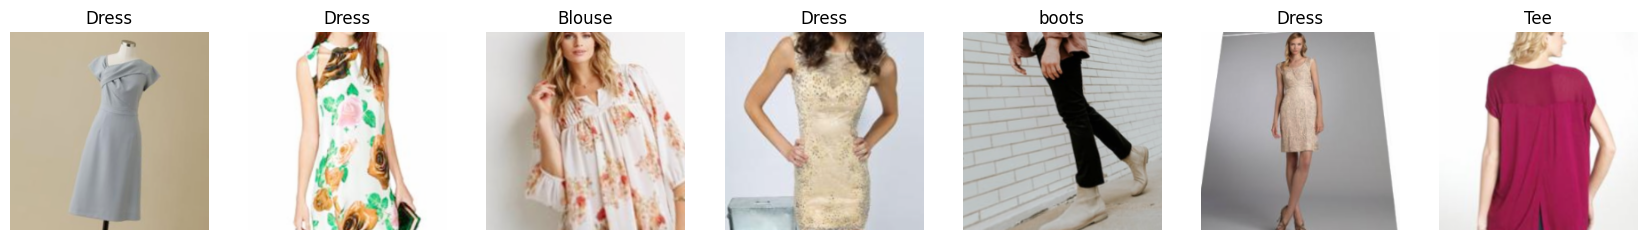

In [138]:
data.show_batch(max_n=7, nrows=1)

## Model Training

In [139]:
learn = cnn_learner(data, resnet34, metrics=[accuracy,error_rate], pretrained=True)
learn.fine_tune(3)
learn.save('stage-1_resnet34')

/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eltrujo/Repo/FastFit_AI-1/FastFit_AI_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Path('../Dataset/models/stage-1_resnet34.pth')

In [140]:
gc.collect()
torch.cuda.empty_cache()

### Learning rate finder

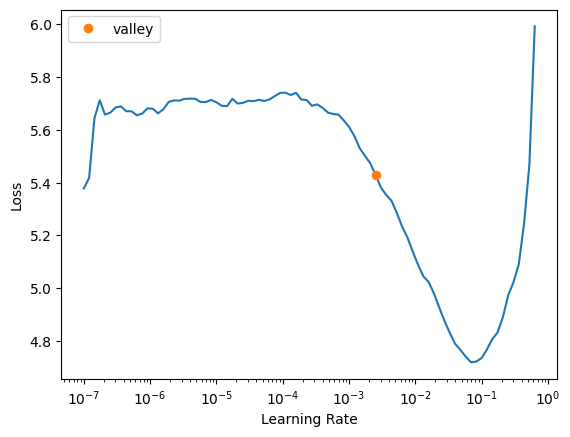

In [141]:
learn = cnn_learner(data, resnet34, metrics=accuracy)
lr_steep = learn.lr_find()

In [142]:
lr_steep

SuggestedLRs(valley=0.002511886414140463)

In [143]:
gc.collect()
torch.cuda.empty_cache()

In [144]:
learn.fine_tune(8, base_lr=5e-3)

### Discriminative Learning Rates

In [145]:
gc.collect()
torch.cuda.empty_cache()

In [146]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

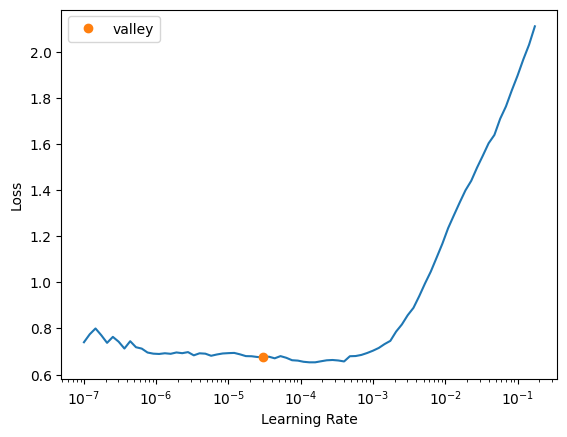

In [147]:
learn.lr_find()

In [148]:
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-3))

SuggestedLRs(valley=2.511886486900039e-05)

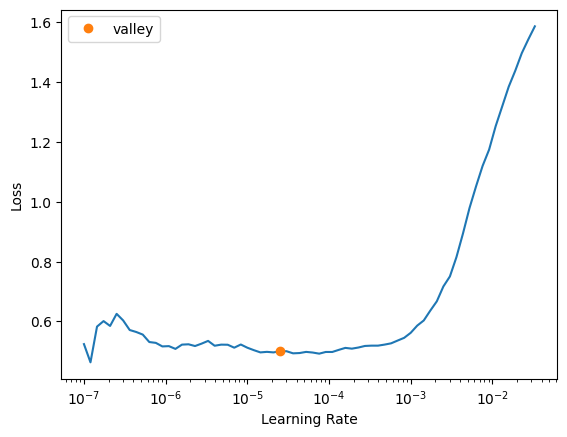

In [149]:
learn.lr_find()

In [151]:
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-3))

### Export model

In [154]:
modelname = learn.model
modelname.cpu()
torch.save(modelname, '../Model/stage-1_resnet34.pkl')

## Evaluation